# Week7 - Decision Tree HW

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.model_selection import train_test_split




In [117]:
# DON'T CHANGE ANYTHING HERE....
random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )
    
    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000
    
    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]
    
    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6
    
    remove_values(df, df.columns, perc=0.05)
    
    return df, pd.Series(y)
    
X, y = create_df()

In [118]:
# checking the head top 5 values using head function
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [119]:
# checking the head top 5 values using head function
y.head()

0    1
1    0
2    0
3    0
4    1
dtype: int32

0    500009
1    499991
dtype: int64

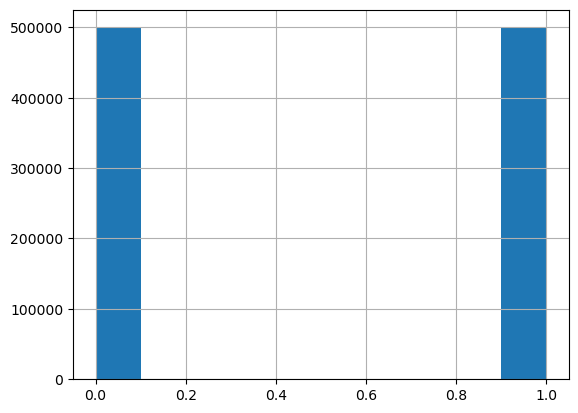

In [120]:
#plotting histogram to check values of 0 and 1
y.hist()
y.value_counts()


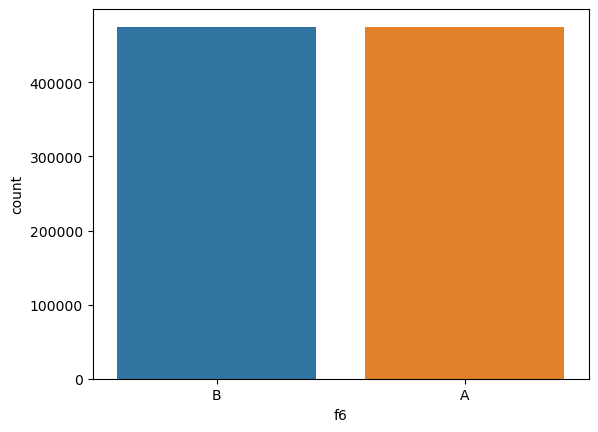

In [121]:
#checking F6 categorical value distribution
X['f6'].value_counts()
sns.countplot(x='f6', data=X)
plt.show()

In [164]:
#using isna and sum function to calculate the sum of values 
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

In [123]:
#checking the shape 
X.shape


(1000000, 6)

In [124]:
#checking data types for all the columns 
print(X.dtypes)

f1    float64
f2    float64
f3    float64
f4    float64
f5    float64
f6     object
dtype: object


In [125]:
# Checking the number of missing values in each column using isna and sum function to calculate the sum of values 

print(X.isna().sum())


f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64


In [126]:
#checking the statistical details using describe 
print(X.describe())

                 f1            f2             f3             f4             f5
count  9.499330e+05  9.498840e+05  949804.000000  950444.000000  950149.000000
mean   2.970269e+00  2.698242e+00       1.203865      -0.002337      -0.000394
std    4.223559e+00  3.863111e+00    1441.308642       1.682211       1.683646
min    7.464873e-15  4.200556e-12   -6319.721066      -8.364699      -7.067953
25%    3.265102e-01  3.144912e-01   -1077.181298      -1.172712      -1.186616
50%    1.415231e+00  1.310581e+00    -403.563631       0.067817       0.001923
75%    3.905995e+00  3.501739e+00    1009.950057       1.156616       1.152483
max    9.069379e+01  8.512300e+01    7402.596849       9.717087       8.354947


1.  1,000,000 rows and 6 columns 
2. There are close to 5%  na values in every column i,e around 50000 values 
3. The data types are correct f6 is object and rest are float
4. The histogram and the count values of y show the data is equally distributed 
5. The count of f6 also shows that A and B are equally distributed and theres no bias 

Explainations...

Explain your gameplan...

# Pipeline Gameplan : 


Handle Missing Values: Numerical features: Use median imputation to fill in missing values.

Categorical features: Use most frequent imputation to replace missing categories.

Scale the Data: Some features have much larger values compared to others, which could negatively impact model performance. Standardization ensures all features are on a similar scale.

Encode Categorical Variables: Use OneHotEncoder to convert categorical variables into numerical format,

Train Models: Use Decision Tree Classifier and Random Forest Classifier as the models to predict the target variable.

Evaluate the Models: Since the dataset is relatively balanced, accuracy is a suitable metric to evaluate performance. 

In [165]:
#seperating the numerical and categorical features
numerical_features = ['f1', 'f2', 'f3', 'f4', 'f5']
categorical_features = ['f6']

# using imputer to input mean in na values and also using scaler normalize
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])

#Using imputer to substitute most frequent and ignore the unknown 
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

In [128]:
#using column transfer to make this into a prepocessing timeline
preprocessing_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])
preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['f6'])])

# Metric
The appropriate metric for this task is accuracy since the target classes (0 and 1) are equally distributed

## HW

In [129]:
#splitting the test set 
Xs = X[:10000]
ys= y[:10000]

<Axes: >

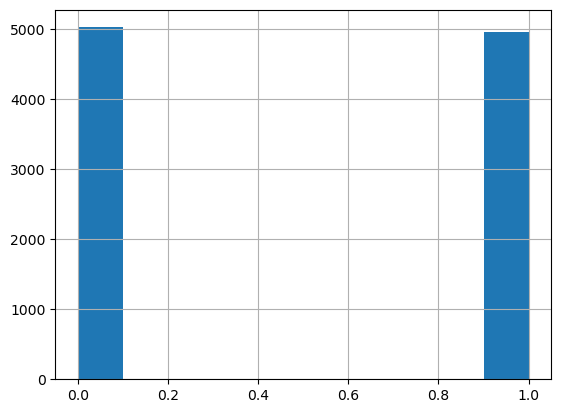

In [130]:
#checking the distribution using histograms
ys.hist()

In [131]:
#dividing data into x train, test, and y train test 
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.3, random_state=42)


In [166]:
#combining the preprocessing pipeline with decision tree 
dt_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [133]:
#Fitting the data and predicting on x test 
dt_modeling_pipeline.fit(X_train, y_train)

y_pred_dt = dt_modeling_pipeline.predict(X_test)

# Defining the params

    max_depth: Limits how deep the tree can grow. Deeper trees can learn more, but they might overfit.
    min_samples_split: Controls the minimum number of data points required to split an internal node.
    min_samples_leaf: Sets the minimum number of data points needed in a leaf node (the end of a branch).

In [169]:
#defining the parms for hyertuning
dt_param_grid = [
    {
        'ml__max_depth': [3,7,10],
        'ml__min_samples_split': [ 8,10,40],
        'ml__min_samples_leaf': [3, 4, 10]
    }
]

scoring ='accuracy'
#fitting the data and using parms for prediction 
dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [170]:
#getting the best parameters 
dt_gcv_results.best_params_

{'ml__max_depth': 10, 'ml__min_samples_leaf': 10, 'ml__min_samples_split': 10}

In [171]:
#score for training 
dt_gcv_results.score(X_train, y_train)

0.847

In [172]:
#score for testing
dt_gcv_results.score(X_test, y_test)

0.7866666666666666

1st Hyperparameter Set:
1. 'ml__max_depth': [5, 10, 15]
2. 'ml__min_samples_split': [2, 5, 10]
3. 'ml__min_samples_leaf': [1, 2, 5]

When I used the above set the best parms were  {'ml__max_depth': 10, 'ml__min_samples_leaf': 2, 'ml__min_samples_split': 10}
However, The training data accuracy was 87.1% and the test data accuracy was 77.8% which shows significant issues. This might show the model might be memorizing the data.

After tuning the hyperparameter set to 
1. 'ml__max_depth': [3, 7, 10]
2. 'ml__min_samples_split': [4, 8, 12]
3. 'ml__min_samples_leaf': [3, 4, 5]
the best params were {'ml__max_depth': 7, 'ml__min_samples_leaf': 5, 'ml__min_samples_split': 12}  The training data accuracy was 81.7% and the test data accuracy was 78.83% which shows that the difference has reduced and the model can now predict better on unseen data tests 

Lesser max depth and increased sample leaf and sample split give better resuts on the unseen model.


# Defining the params

    n_estimators: The number of trees in the forest. More trees generally improve performance but take longer to train.
    max_depth: Limits how deep each tree can grow, just like in Decision Tree.
    min_samples_split: Minimum data points needed to split a node. Higher values create simpler trees, reducing overfitting.
    min_samples_leaf: Minimum data points allowed in leaf nodes. Helps prevent the model from creating too many small branches.

In [138]:
#clubbing the pipeline with Random Forest 
rf_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [139]:
#using params for Random forest 
rf_param_grid = {
    'ml__n_estimators': [ 25,30],
    'ml__max_depth': [5, 10],
    'ml__min_samples_split': [5, 50],
    'ml__min_samples_leaf': [ 5,75]
}

scoring = 'accuracy'
#fitting the data and using parms for prediction 
rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [140]:
#getting the best parameters 
rf_gcv_results.best_params_

{'ml__max_depth': 10,
 'ml__min_samples_leaf': 5,
 'ml__min_samples_split': 5,
 'ml__n_estimators': 30}

In [141]:
#score for training 
rf_gcv_results.score(X_train, y_train)

0.852

In [142]:
#score for testing
rf_gcv_results.score(X_test, y_test)

0.812

Explain __shortly__ your findings how did you address the issues.

1st set :
1. 'ml__n_estimators': [50, 100],
2. 'ml__max_depth': [100, 150],
3. 'ml__min_samples_split': [2, 5],
4. 'ml__min_samples_leaf': [1, 2]
Training Accuracy: 98% Test Accuracy: 0.823 (~82.3%) The large gap between train (98%) and test (82.3%) indicates severe overfitting. Trying to reduce the overfitting in the next set of values

2nd 
1. 'ml__n_estimators': [50, 100],
2. 'ml__max_depth': [5, 10],
3. 'ml__min_samples_split': [2, 5],
4. 'ml__min_samples_leaf': [1, 2]

Training Accuracy: 87.7% Test Accuracy: 81.7% The smaller gap between train (87.7%) and test (81.7%) indicates that this model generalizes better, with less overfitting. Acheived this by significantly reducing the max depth. The toverfitting gap has reduced in this itteration. Trying to further improve this in the next itteration

3rd 
1. 'ml__n_estimators': [ 25,30],
2. 'ml__max_depth': [5, 10],
3. 'ml__min_samples_split': [5, 50],
4. 'ml__min_samples_leaf': [ 5,75]

Training 0.8564285714285714
Test 0.8113333333333334


How it was done 
To tune this the max depth was reduced significantly and the sample split and sample leaf was increased.

The overfitting is less in the 3rd this provides a good balance as the overfitting gap is less compared to the obove trial knob values. The best parameters are {'ml__max_depth': 10, 'ml__min_samples_leaf': 5, 'ml__min_samples_split': 5,'ml__n_estimators': 25}.

Explain which model would you go with? 

The third set of Random Forest i,e
1. 'ml__n_estimators': [ 25,30],
2. 'ml__max_depth': [5, 10],
3. 'ml__min_samples_split': [5, 50],
4. 'ml__min_samples_leaf': [ 5,75]

Offers comparetively more accuracy and less over fitting. Hence choosing it as the final model.

In [173]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

#creating a fina; pipeline using Random forest and 3 iter values 
rf_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', RandomForestClassifier(
        n_estimators=25,  
        max_depth=10,     
        min_samples_split=5, 
        min_samples_leaf=5,  
        random_state=42      
    ))
])
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        min_samples_split=5, n_estimators=25,
                                        random_state=42))])

In [144]:
#Fitting and testing the data on the new pipeline
rf_modeling_pipeline.fit(X_train, y_train)

y_pred_rf = rf_modeling_pipeline.predict(X_test)

In [174]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#getting evaluation values. Checking other metrics just to check the performance
print("Final Random Forest Model Performance:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Final Random Forest Model Performance:
Test Accuracy: 0.8070
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1501
           1       0.82      0.78      0.80      1499

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000

Confusion Matrix:
 [[1250  251]
 [ 328 1171]]


Explain results

Accuracy: This means the model correctly predicted the class labels for 80.7% of the test samples.

Precision:
1. Class 0: 79% of predictions Class 0 were correct.
2. Class 1: 82% of predictions Class 1 were correct.

Recall: 
1. The model correctly identified 83% of all Class 0 instances.
2. The model correctly identified 78% of all Class 1 instances.

F1-Score::
The harmonic mean of precision and recall. It balances false positives and false negatives. F1-scores for both classes are around 0.80-0.81, indicating balanced performance.

Confusion Matrix:
251 were incorrectly predicted as Class 1 (False Positives) 328 were (False Negatives). Theres no sever imbalance

# Conclusion:
The data pipeline ensures the input data is preprocessed effectively by handling missing values, scaling numerical features, and encoding categorical features. Numerical missing values are replaced with the median, while categorical ones are filled with the most frequent category. This preprocessing helps the model handle inconsistencies in the data and ensures that features are in a comparable range, improving model performance.

After performing hyperparameter tuning and training the Random Forest model, the model achieved a balanced accuracy of around 80%. This indicates that the model performs consistently well across both classes, ensuring neither class is disproportionately favored. The balanced accuracy suggests that the model is reliable in maintaining good precision and recall for each class, meaning it correctly predicts both positive and negative outcomes while minimizing false positives and false negatives.

The overall performance of the Random Forest model demonstrates good and balanced.